<a href="https://colab.research.google.com/github/lkhart/kaggle_digit_recognizer/blob/main/digit_recognizer_rf_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Digit Recognizer**

#### [Kaggle Competition Entry](https://www.kaggle.com/c/digit-recognizer/overview)/Class Assignment 
#### Laura Hart - MSDS 422 - Winter 2022

The objective of this exercise is to apply classification techniques to correctly identify digits (0-9) from a dataset of tens of thousands of handwritten images. Each image is 28x28 pixels in size, and each pixel is represented in the dataset as one column (pixel0, pixel1, ..., pixel784). The value within that column represents the darkness of that pixel, with values ranging from 0 (lightest) to 255 (darkest). One row of pixel values represents one 28x28pixel image of a handwritten digit.

## Management/Research Question: Practical Application
This classification problem can be applied to numerous real-world problems, such as automatic mail sorting or converting handwritten files to a digital format. A successful classifier model must be able to correctly label digits written in different sizes and styles; the appearance of a digit is not expected to be consistent, but a successful model will identify the patterns that distinguish each label from the others.





## Setup

In [1]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA

In [3]:
train_df = pd.read_csv('train.csv')
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
# train_df details (number of rows used later)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [5]:
test_df = pd.read_csv('test.csv')
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
# test_df details (number of rows used later)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


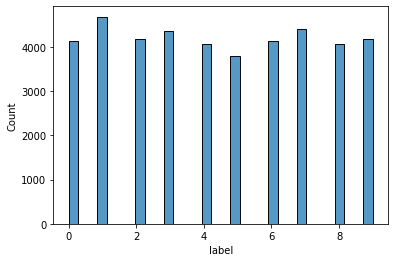

In [6]:
# distribution of label value in train data
sns.histplot(x='label', data=train_df)

As displayed in the above plot, the label values appear to are nearly uniformly distributed among the training data. There is no class imbalance within the dataset, and no corrective sampling technique will be needed when splitting the data into train/validation sets.

## Modeling 

We will apply the following techniques to predict labels on this dataset:
-   Random Forest Classifier
-   Random Forest Classifer with Principal Component Analysis (PCA)
-   K-Means Clustering

In [7]:
# set seed for reproducibility
np.random.seed(123)
# train-test split
X_train, X_test, y_train, y_test = train_test_split(train_df.iloc[:, 1:], train_df.iloc[:, 0], test_size=0.20)

### Random Forest Classifier

In [8]:
rf_van = RandomForestClassifier()

In [12]:
# fit rf model and report elapsed time
start = datetime.now()

rf_van.fit(X_train, y_train)

end = datetime.now()
print('elapsed time: ', end-start)

elapsed time:  0:00:23.612507


In [14]:
# apply fitted rf model to validation set and report elapsed time
start = datetime.now()

rf_van_test = rf_van.predict(X_test)
print('accuracy score: ', accuracy_score(rf_van_test, y_test))

end = datetime.now()
print('elapsed time: ', end-start)

accuracy score:  0.9639285714285715
elapsed time:  0:00:01.084259


In [17]:
# predict on final test set for kaggle submission
rf_van_pred = rf_van.predict(test_df)

rf_van_labels = pd.Series(rf_van_pred, name='Label')

rf_van_submit = pd.concat([pd.Series(range(1,28001), name='ImageID'), rf_van_labels], axis = 1)

In [18]:
print(rf_van_submit)

       ImageID  Label
0            1      2
1            2      0
2            3      9
3            4      4
4            5      3
...        ...    ...
27995    27996      9
27996    27997      7
27997    27998      3
27998    27999      9
27999    28000      2

[28000 rows x 2 columns]


In [19]:
# export final predictions
rf_van_submit.to_csv('rf_van_submit.csv', index=False)

files.download('rf_van_submit.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

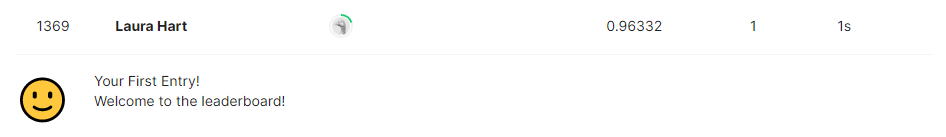

### Random Forest Classifier with PCA

In [11]:
# combine train and test dfs so that transformations apply to both
all_data = (train_df.iloc[:, 1:]).append(test_df)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 419.2 MB


While scaling was unnecessary when applying random forest alone, it is necessary to scale data before performing PCA. Applying starndard scaler accordingly.

In [12]:
sscaler = StandardScaler()
all_data_scaled = sscaler.fit_transform(all_data)

In [24]:
pca = PCA(n_components=0.95)

In [26]:
# execute PCA on combined datasets and report elapsed time
start = datetime.now()

pca.fit(all_data_scaled)
all_data_reduced = pca.transform(all_data_scaled)

end = datetime.now()
print('elapsed time: ', end-start)

elapsed time:  0:00:18.002386


In [27]:
pca.n_components_

332

In [28]:
# re-split the original train and test data by index
X_train_pca = all_data_reduced[:42000, :]
test_df_pca = all_data_reduced[42000:, :]


In [30]:
# recreate 80% train and 20% 'test'/validation split
# set seed for reproducibility
np.random.seed(123)
X_train, X_test, y_train, y_test = train_test_split(X_train_pca, train_df.iloc[:, 0], test_size=0.20)

In [31]:
rf_pca = RandomForestClassifier()

In [32]:
# fit rf model and report elapsed time
start = datetime.now()

rf_pca.fit(X_train, y_train)

end = datetime.now()
print('elapsed time: ', end-start)

elapsed time:  0:01:38.542713


In [33]:
# apply fitted rf model to validation set and report elapsed time
start = datetime.now()

rf_pca_test = rf_pca.predict(X_test)
print('accuracy score: ', accuracy_score(rf_pca_test, y_test))

end = datetime.now()
print('elapsed time: ', end-start)

accuracy score:  0.9285714285714286
elapsed time:  0:00:00.345678


In [35]:
# predict on final test set for kaggle submission
rf_pca_pred = rf_pca.predict(test_df_pca)

rf_pca_labels = pd.Series(rf_pca_pred, name='Label')

rf_pca_submit = pd.concat([pd.Series(range(1,28001), name='ImageID'), rf_pca_labels], axis = 1)

In [36]:
print(rf_pca_submit)

       ImageID  Label
0            1      2
1            2      0
2            3      9
3            4      4
4            5      3
...        ...    ...
27995    27996      9
27996    27997      7
27997    27998      3
27998    27999      9
27999    28000      2

[28000 rows x 2 columns]


In [37]:
# export final predictions
rf_pca_submit.to_csv('rf_pca_submit.csv', index=False)

files.download('rf_pca_submit.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

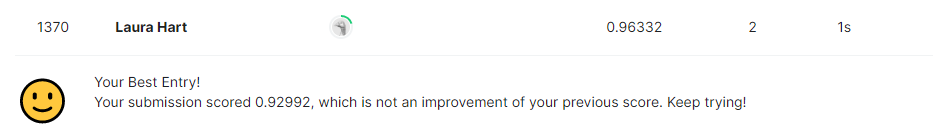

### K-Means Clustering

In [7]:
# set seed for reproducibility
np.random.seed(123)
# train-test split (redoing after PCA to return to original dataset)
X_train, X_test, y_train, y_test = train_test_split(train_df.iloc[:, 1:], train_df.iloc[:, 0], test_size=0.20)

In [8]:
print(X_train.shape)

(33600, 784)


In [13]:
sscaler.fit(train_df.iloc[:, 1:])
X_train = sscaler.transform(X_train)
test_df = sscaler.transform(test_df)

In [14]:
n_digits = len(np.unique(y_test))
print(n_digits)

10


In [15]:
# Initialize KMeans model
kmeans = MiniBatchKMeans(n_clusters = n_digits)

In [34]:
# Fit model to training data
kmeans.fit(X_train)


MiniBatchKMeans(n_clusters=10)

In [35]:
kmeans.labels_

array([8, 1, 8, ..., 1, 2, 1], dtype=int32)

In [36]:
len(kmeans.labels_)

33600

The labels assigned by this K-Means algorithm do not actually refer to the final integer labels we intend to submit; rather, they just refer to the cluster each image was assigned to. The following process predicts which actual integer Label should be assigned to each cluster.

In [37]:
def retrieve_info(cluster_labels, y):
  # initializing
  reference_labels = {}

  # for loop to run through each label of cluster label
  for i in range(len(np.unique(kmeans.labels_))):

    index = np.where(cluster_labels == i,1,0)
    num = np.bincount(y[index==1]).argmax()
    reference_labels[i] = num

  return reference_labels

In [38]:
reference_labels = retrieve_info(kmeans.labels_, y_train)
print(reference_labels)

{0: 5, 1: 9, 2: 0, 3: 3, 4: 6, 5: 3, 6: 1, 7: 0, 8: 8, 9: 6}


In [39]:
number_labels = np.random.rand(len(kmeans.labels_))
print(number_labels)

[0.35169116 0.57607059 0.52712471 ... 0.25838041 0.04569939 0.38669843]


In [40]:
len(number_labels)

33600

In [42]:
for i in range(len(kmeans.labels_)):
  number_labels[i] = reference_labels[kmeans.labels_[i]]

In [43]:
print(number_labels)

[8. 9. 8. ... 9. 0. 9.]


In [44]:
# print accuracy score of labels
print(accuracy_score(number_labels, y_train))

0.4644345238095238


In [45]:
kmeans_pred = kmeans.predict(test_df)

In [46]:
len(kmeans_pred)

28000

In [47]:
number_labels = np.random.rand(len(kmeans_pred))
print(number_labels)

[0.28310592 0.44361504 0.23359843 ... 0.23597199 0.35371597 0.8813247 ]


In [50]:
for i in range(len(kmeans_pred)):
  number_labels[i] = reference_labels[kmeans.labels_[i]]

In [51]:
print(number_labels)

[8. 9. 8. ... 9. 1. 6.]


In [52]:
len(number_labels)

28000

In [53]:
Id = []
for i in range(1, len(number_labels) + 1):
  Id.append(i)


In [54]:
# organize final test set for kaggle submission

kmeans_labels = pd.DataFrame(list(zip(Id, number_labels)), columns = ['ImageId', 'Label'])


In [55]:
print(kmeans_labels)

       ImageId  Label
0            1    8.0
1            2    9.0
2            3    8.0
3            4    1.0
4            5    1.0
...        ...    ...
27995    27996    0.0
27996    27997    1.0
27997    27998    9.0
27998    27999    1.0
27999    28000    6.0

[28000 rows x 2 columns]


In [56]:
# export final predictions
kmeans_labels.to_csv('kmeans_labels.csv', index=False)

files.download('kmeans_labels.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Conclusion

Based on the performance of all three models and the relative compute time required, I would propose the random forest model as most successful. It had more in the competition submission vs the PCA random forest, but with fewer steps and reduced computing time.